In [5]:
import sqlite3
import pandas as pd
import polars as pl
pd.options.mode.chained_assignment = None

import sys
sys.path.append('../')
sys.path.append('../networks')

from functions.env import  DB_SCIENCE_PATH_NEW, GRAPH_RESULTS

conn = sqlite3.connect(DB_SCIENCE_PATH_NEW)

from functions.datamodel import OptimumParameter
from functions.feat_network import get_edge_node_table
from functions.feat_visualization import sygma_graph_leiden
from optimal_clustering import optimal_clustering

dict_op = optimal_clustering
dict_op = OptimumParameter(**dict_op)


import numpy as np
# Function to calculate cosine similarity between position vectors
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    return dot_product / (norm1 * norm2)


import warnings

# Use the filterwarnings function to filter and suppress FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import glob

list_df = []
paths = glob.glob('../networks/data/weighted/*')
for path in paths:
    df = pd.read_csv(path, index_col = [0])
    df = df[['wikidata_id', 'meta_occupation']]
    df['meta_occupation'] = df['meta_occupation'].apply(lambda x: x.split(' | '))
    df = df.explode('meta_occupation')
    df = df.reset_index(drop=True)
    df.columns = ['source', 'target']
    df['weight'] = 1
    list_df.append(df)


In [3]:
from tqdm import tqdm
new_list_df = []

x = 0
for df_net in tqdm(list_df):

    df_net = pl.from_pandas(df_net)
    df_edge, df_nodes = get_edge_node_table(df_net)
    df_edge = df_edge[['source', 'target', 'weight']]
    matrix = df_edge.pivot(index = 'source', columns = 'target', values = 'weight')
    matrix = matrix.fillna(0)
    np.fill_diagonal(matrix.values, 1.0) # Add 1 to the diagonals
    new_list_df.append(matrix)

100%|██████████| 100/100 [00:02<00:00, 46.55it/s]


In [6]:
list_matrix = [x.sort_index().sort_index(axis=1) for x in new_list_df]

common_index = set(list_matrix[0].index)

# Find the intersection of indices with the rest of the dataframes
for df in list_matrix[1:]:
    common_index = common_index.intersection(df.index)

# Create a new list of dataframes with only the common indices
filtered_dataframes_list = [df.loc[common_index] for df in list_matrix]
filtered_dataframes_list = [x.sort_index().sort_index(axis=1) for x in filtered_dataframes_list]

common_columns = set(filtered_dataframes_list[0].columns)

# Find the intersection of column names with the rest of the dataframes
for df in filtered_dataframes_list[1:]:
    common_columns = common_columns.intersection(df.columns)

# Create a new list of dataframes with only the common columns
final_list = [df[common_columns] for df in filtered_dataframes_list]
final_list = [x.sort_index().sort_index(axis=1) for x in final_list]

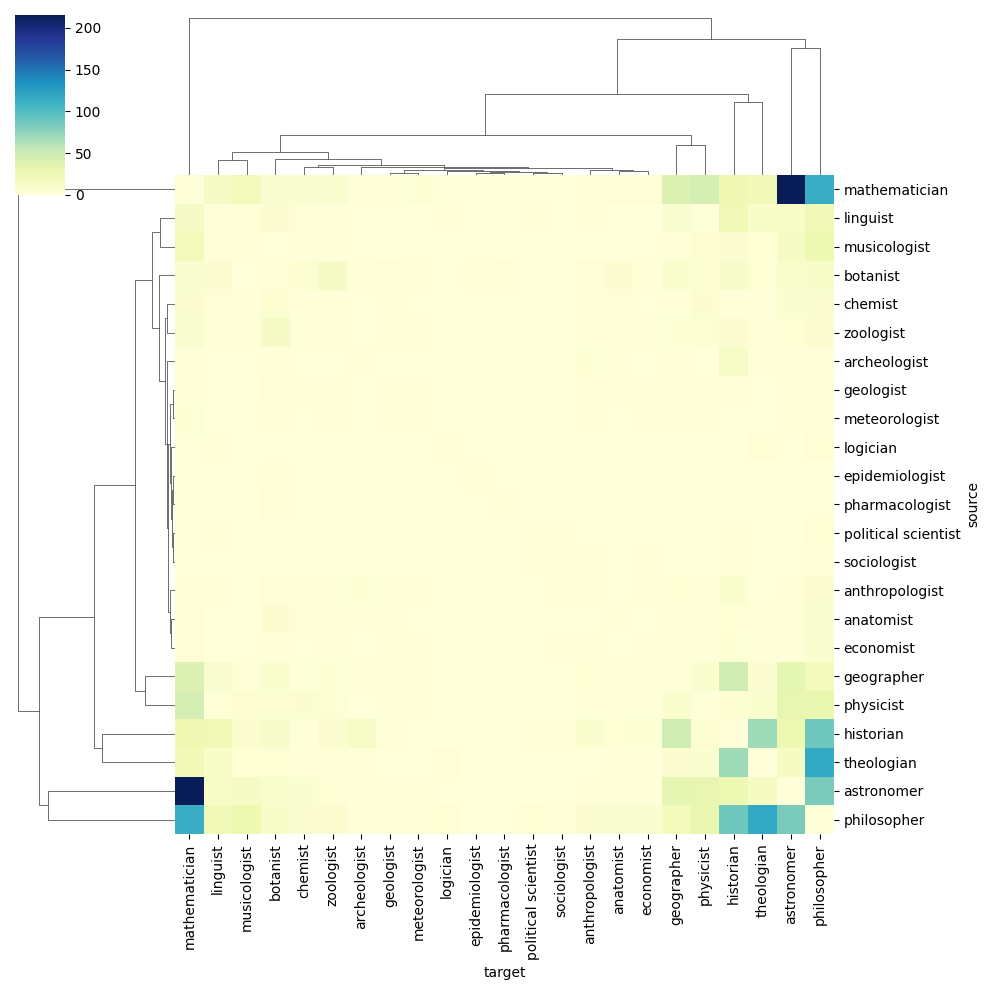

In [7]:
occupations = list(final_list[0].index)

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame from the similarity matrix
#similarity_df = pd.DataFrame(average_distance, index=occupations, columns=occupations)

average_distance = sum(final_list)/len(final_list)
# Create a clustermap
sns.clustermap(average_distance, cmap="YlGnBu", figsize=(10, 10))
plt.show()

In [17]:
df_edges = average_distance.stack().reset_index()
df_edges.columns = ['source', 'target', 'weight']
df_edges

#f_edge_filter = df_edge[df_edge["weight"] >= dict_op.min_count_link]
df_edge_filter = df_edges[
        df_edges["source"] != df_edges["target"]
    ]

df_edge_filter = df_edge_filter[df_edge_filter['weight']>0]
df_edge_filter = df_edge_filter.sort_values(['source', 'weight'], ascending=(False, False))
df_edge_filter["rank_count"] = df_edge_filter.groupby(["source"])["weight"].rank(
        method="first", ascending=False
    )
df_edge_filter = df_edge_filter.reset_index(drop=True)
df_edge_filter = df_edge_filter[df_edge_filter['rank_count']<=3]
df_edge_filter.to_csv('../networks/matrix/weighted_non_normalized.csv')

In [72]:
# Create an undirected graph from the edge list
G = nx.Graph()

# Add edges with weights
for _, row in df_edge_filter.iterrows():
    source = row['source']
    target = row['target']
    weight = row['weight']
    G.add_edge(source, target, weight=weight)


from ipysigma import Sigma

Sigma.write_html(
        G,
        'text.html',
        # node_size=g.degree,
        raw_node_size="node_size",
        node_size="node_size",
        fullscreen=True,
        #node_color="community",
        edge_size="weight",
        #node_label_color="community",
        node_label_color_palette="Dark2",
        node_color_palette="Dark2",
        start_layout=False,
        show_all_labels=True,
        # edge_color_palette="Dark2",
        # edge_color="community",
        # edge_color_from="source",
        # default_node_halo_color = 'white',
        # node_halo_color = 'white',
        # raw_node_halo_color = 'white',
        edge_size_range=(1, 3),
        node_size_range=(3, 10),
        #max_categorical_colors=len(set(df_partition["community"])),
        default_edge_type="curve",
        node_border_color_from="node",
        default_node_label_size=25,
        # node_label_size=g.degree,
        # node_label_size="node_size",
        node_label_size_range=(3, 10),
    )


In [ ]:
from sklearn.preprocessing import normalize

# Calculate the cosine similarity between rows
cosine_sim = np.dot(average_distance, average_distance.T)
cosine_sim = normalize(cosine_sim, axis=1)  # Normalize along rows

cosine_sim_df = pd.DataFrame(cosine_sim, index=average_distance.index, columns=average_distance.index)

sns.clustermap(cosine_sim_df, cmap="YlGnBu", figsize=(10, 10))
plt.show()

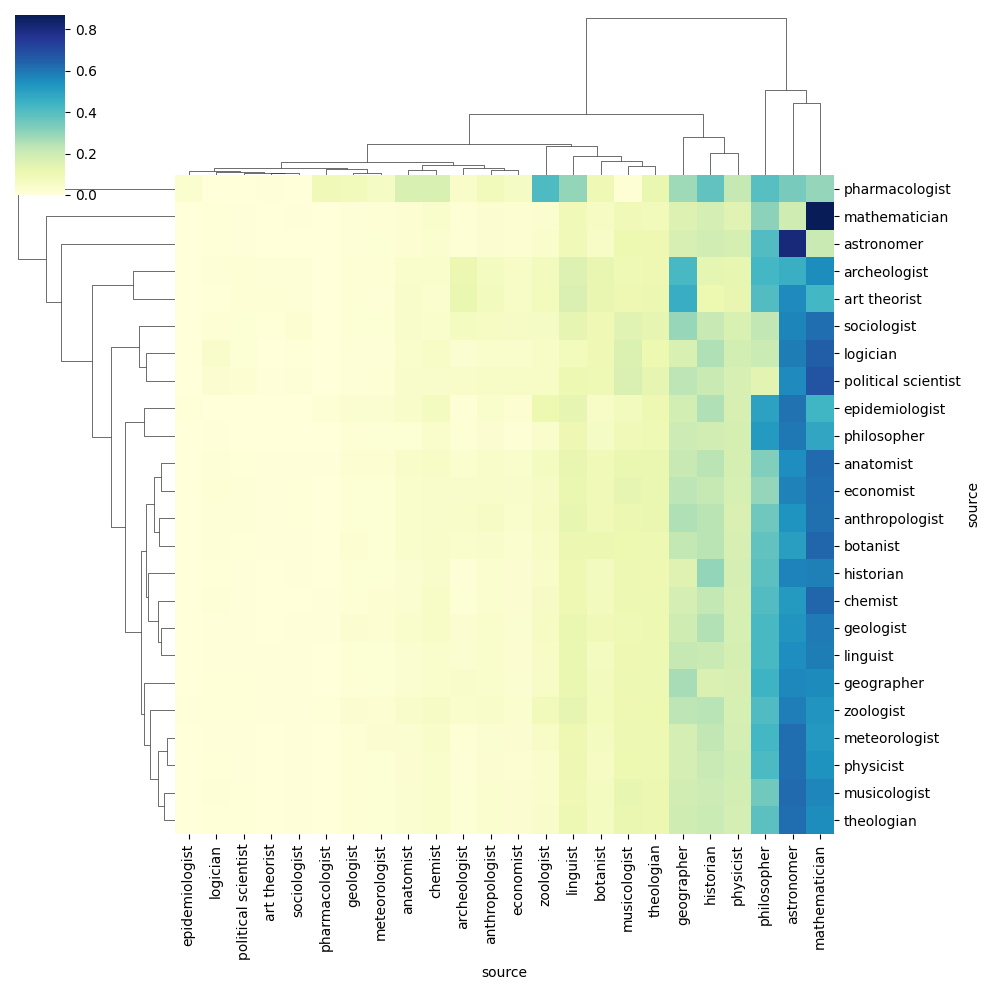

array([0.04432501, 0.04607554, 0.03188851, 0.00386809, 0.54816085,
       0.08998003, 0.04854109, 0.03659538, 0.00294271, 0.2147791 ,
       0.02148408, 0.23757104, 0.12572053, 0.01181114, 0.62711503,
       0.02151756, 0.11965549, 0.00599667, 0.3238033 , 0.17860829,
       0.00994132, 0.00633206, 0.11802732, 0.06866101])

In [3]:
from tqdm import tqdm
final_dict = {}

x = 0
for df_net in tqdm(list_df):

    df_net = pl.from_pandas(df_net)
    df_edge, df_nodes = get_edge_node_table(df_net)
    df_edge = df_edge[['source', 'target', 'weight']]
    df_edge['weight'] = (df_edge['weight'] - df_edge['weight'].min()) / (df_edge['weight'].max() - df_edge['weight'].min())
    final_dict[x] = df_edge
    x=x+1

100%|██████████| 100/100 [00:02<00:00, 47.05it/s]


In [4]:
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


def weighted_jaccard_similarity(matrix1, matrix2):
    """
    Compute the Weighted Jaccard Similarity between two adjacency matrices.
    """
    # Ensure matrices are numpy arrays for element-wise operations
    matrix1 = np.array(matrix1)
    matrix2 = np.array(matrix2)

    # Calculate the minimum (intersection) and maximum (union) for each element
    min_matrix = np.minimum(matrix1, matrix2)
    max_matrix = np.maximum(matrix1, matrix2)

    # Sum the weights for intersection and union
    intersection_weight_sum = np.sum(min_matrix)
    union_weight_sum = np.sum(max_matrix)

    # Compute the similarity
    similarity = intersection_weight_sum / union_weight_sum if union_weight_sum != 0 else 0
    return similarity


def prepare_edge_list(edge1, edge2):

    matrix1 = edge1.pivot(index ='source', columns='target', values='weight')
    matrix1 = matrix1.fillna(0)

    matrix2 = edge2.pivot(index ='source', columns='target', values='weight')
    matrix2 = matrix2.fillna(0)

    labels1 = list(matrix1.index)
    labels2 = list(matrix2.index)
    common_labels = set(labels1).intersection(set(labels2))

    matrix1 = matrix1[common_labels]
    matrix1 = matrix1.reset_index()
    matrix1 = matrix1[matrix1['source'].isin(common_labels)]
    matrix1 = matrix1.set_index('source')

    matrix2 = matrix2[common_labels]
    matrix2 = matrix2.reset_index()
    matrix2 = matrix2[matrix2['source'].isin(common_labels)]
    matrix2 = matrix2.set_index('source')

    matrix1 = matrix1.loc[common_labels, common_labels]
    matrix2 = matrix2.loc[common_labels, common_labels]

    return matrix1, matrix2

In [5]:
# TAKE 4 Minutes

from tqdm import tqdm

datasets = final_dict.copy()
datasets[0]

# Create an empty DataFrame to store the ARI values
ari_df = pd.DataFrame(columns=['Dataset 1', 'Dataset 2', 'metric'])

# Iterate over pairs of datasets and compute the ARI
for dataset1_name, dataset1 in tqdm(datasets.items()):
    for dataset2_name, dataset2 in datasets.items():
        # Get the common elements based on the 'node' column

        dataset1 = dataset1[['source', 'target', 'weight']]
        dataset2 = dataset2[['source', 'target', 'weight']]

        matrix1, matrix2 = prepare_edge_list(dataset1, dataset2)
        matrix1, matrix2 = matrix1.to_numpy(), matrix2.to_numpy()

        score = weighted_jaccard_similarity(matrix1.flatten(), matrix2.flatten())
        ari_df = ari_df.append({'Dataset 1': dataset1_name, 'Dataset 2': dataset2_name, 'metric': score}, ignore_index=True)

100%|██████████| 100/100 [07:01<00:00,  4.22s/it]


In [6]:
matrix_df = ari_df.pivot(index='Dataset 1', columns='Dataset 2', values='metric')

0.8505199119181818


<AxesSubplot: >

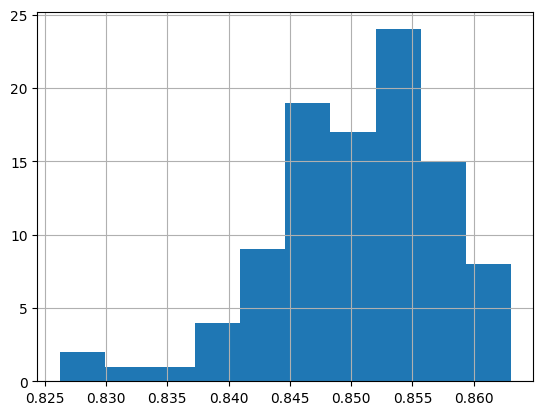

In [7]:
print(matrix_df.mean().mean())
matrix_df.mean().hist()


#0.856659510169097

In [42]:
import numpy as np

df_mean = matrix_df.mean().reset_index()
df_mean = df_mean.sort_values(0, ascending=False)
#df_mean['count_occupations'] = df_mean['Dataset 2'].apply(lambda x : len(set(list_df[int(x)].target)))
#df_mean = df_mean[df_mean['count_occupations']==28]
df_mean

,Dataset 2,0
1,1.0,0.863019
88,88.0,0.860865
45,45.0,0.860728
35,35.0,0.860486
67,67.0,0.860189
...,...,...
3,3.0,0.838537
18,18.0,0.836960
4,4.0,0.833592
36,36.0,0.826963


In [163]:
# compute average distance:
import pickle
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

list_matrix = []
for element in tqdm(list_df):
    df_net = pl.from_pandas(element)
    df_edge, df_nodes = get_edge_node_table(df_net)
    df_edge.to_csv(f"../networks/matrix/weighted_optimized_before_1700.csv")

    df_edge_filter = df_edge[df_edge["weight"] >= dict_op.min_count_link]
    df_edge_filter = df_edge_filter[
        df_edge_filter["source"] != df_edge_filter["target"]
    ]

    df_edge_filter = df_edge_filter[
        df_edge_filter["rank_count"] <= 3
    ]

    df_edge_filter = df_edge_filter[['source', 'target', 'weight']].copy()

    _, g = sygma_graph_leiden(
    df_edge_filter,
    df_nodes,
    edge_bins=10,
    node_bins=10,
    filepath='../graph/best_jaccard.html',
)
    
    pos = nx.spring_layout(g)
    occupations = list(g.nodes())

    similarity_matrix = np.zeros((len(occupations), len(occupations)))

    for i, occupation_i in enumerate(occupations):
        for j, occupation_j in enumerate(occupations):
            pos_i = pos[occupation_i]
            pos_j = pos[occupation_j]
            similarity_matrix[i][j] = cosine_similarity(pos_i, pos_j)

    # Create a DataFrame from the similarity matrix
    similarity_df = pd.DataFrame(similarity_matrix, index=occupations, columns=occupations)
    list_matrix.append(similarity_df)



100%|██████████| 100/100 [01:23<00:00,  1.19it/s]


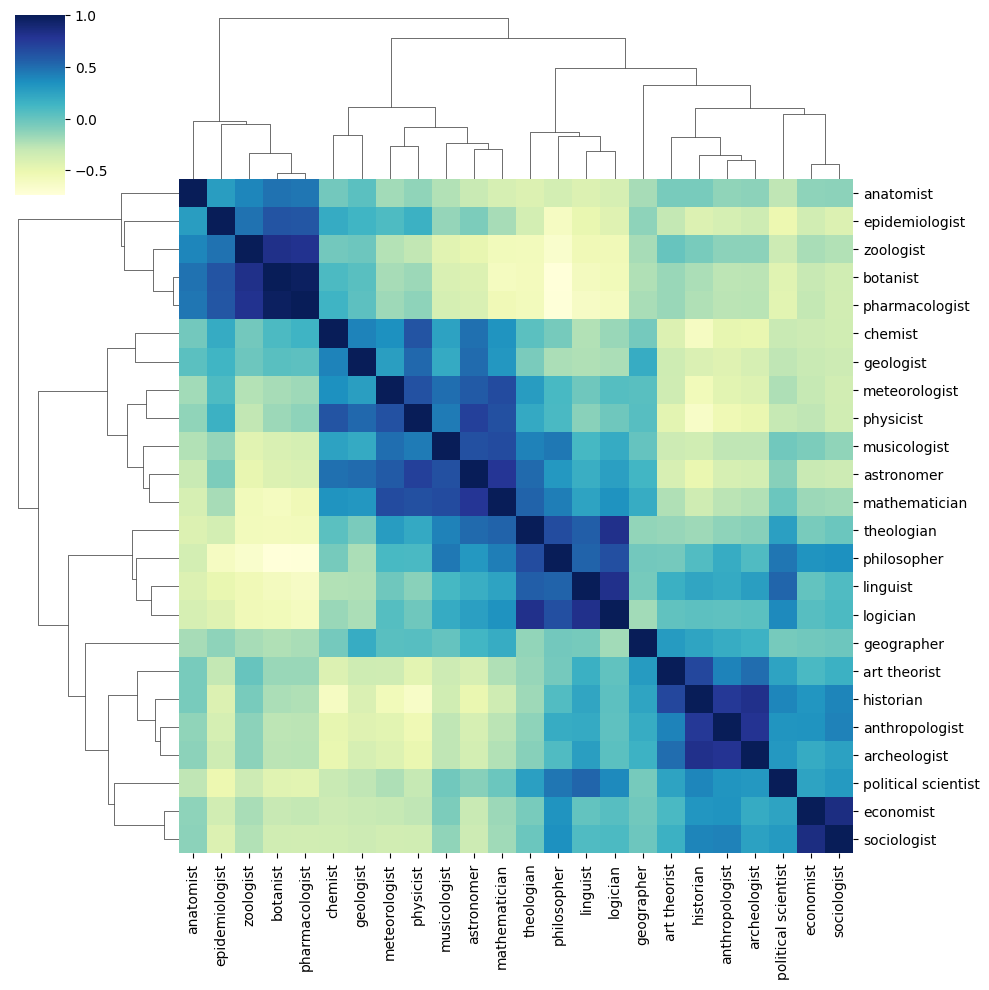

In [165]:
list_matrix = [x.sort_index().sort_index(axis=1) for x in list_matrix]

common_index = set(list_matrix[0].index)

# Find the intersection of indices with the rest of the dataframes
for df in list_matrix[1:]:
    common_index = common_index.intersection(df.index)

# Create a new list of dataframes with only the common indices
filtered_dataframes_list = [df.loc[common_index] for df in list_matrix]
filtered_dataframes_list = [x.sort_index().sort_index(axis=1) for x in filtered_dataframes_list]

common_columns = set(filtered_dataframes_list[0].columns)

# Find the intersection of column names with the rest of the dataframes
for df in filtered_dataframes_list[1:]:
    common_columns = common_columns.intersection(df.columns)

# Create a new list of dataframes with only the common columns
final_list = [df[common_columns] for df in filtered_dataframes_list]
final_list = [x.sort_index().sort_index(axis=1) for x in final_list]

occupations = list(final_list[0].index)
average_distance = sum(final_list)/len(final_list)

# Create a DataFrame from the similarity matrix
#similarity_df = pd.DataFrame(average_distance, index=occupations, columns=occupations)

# Create a clustermap
sns.clustermap(average_distance, cmap="YlGnBu", figsize=(10, 10))
plt.show()


In [160]:
# Create a graph
G = nx.Graph()

# Add nodes (column names)
G.add_nodes_from(average_distance.columns)

# Iterate through the DataFrame and add edges with weights (pairwise distances)
for i in range(len(average_distance.columns)):
    for j in range(i + 1, len(average_distance.columns)):
        G.add_edge(average_distance.columns[i], average_distance.columns[j], weight=average_distance.iloc[i, j])

from ipysigma import Sigma

Sigma.write_html(
        G,
        'text.html',
        # node_size=g.degree,
        raw_node_size="node_size",
        node_size="node_size",
        fullscreen=True,
        #node_color="community",
        edge_size="weight",
        #node_label_color="community",
        node_label_color_palette="Dark2",
        node_color_palette="Dark2",
        start_layout=False,
        show_all_labels=True,
        # edge_color_palette="Dark2",
        # edge_color="community",
        # edge_color_from="source",
        # default_node_halo_color = 'white',
        # node_halo_color = 'white',
        # raw_node_halo_color = 'white',
        edge_size_range=(1, 3),
        node_size_range=(3, 10),
        #max_categorical_colors=len(set(df_partition["community"])),
        default_edge_type="curve",
        node_border_color_from="node",
        default_node_label_size=25,
        # node_label_size=g.degree,
        # node_label_size="node_size",
        node_label_size_range=(3, 10),
    )


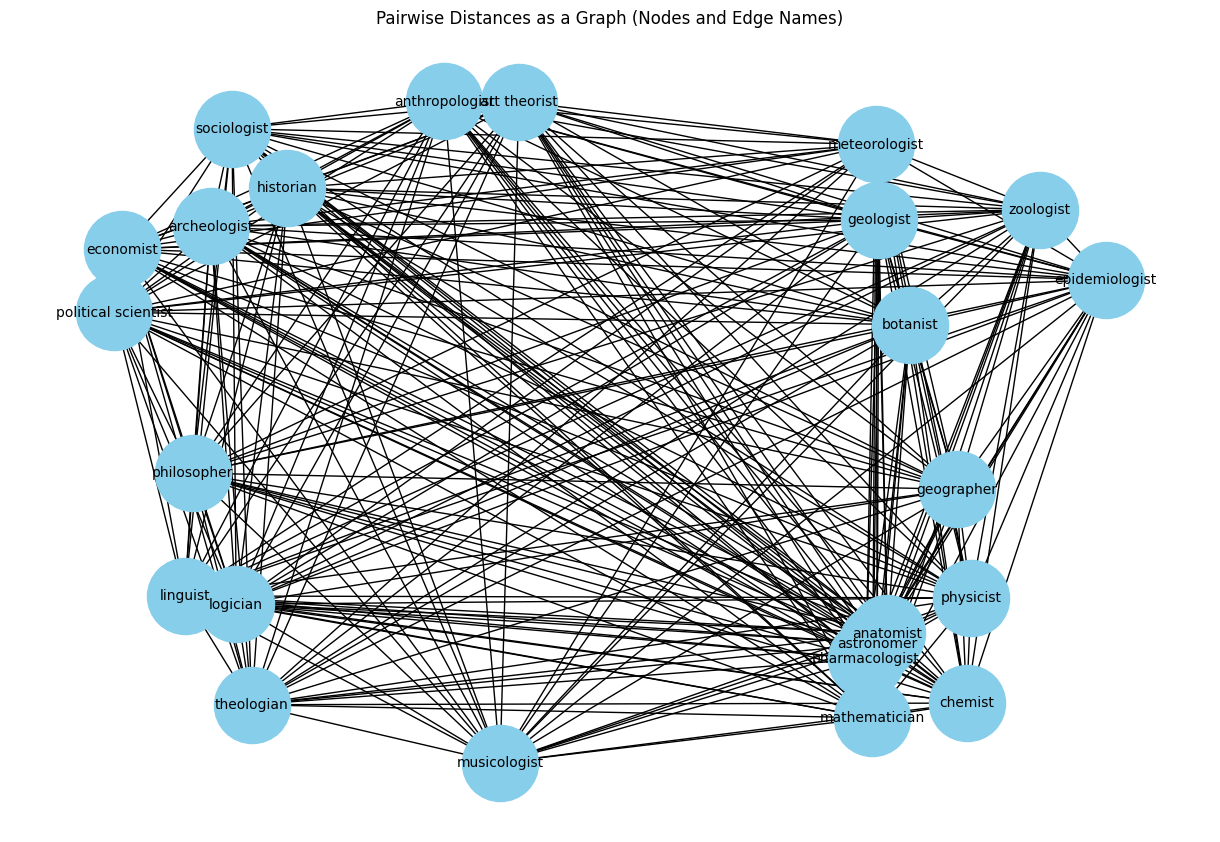

In [168]:


# Draw the graph with only nodes and edge names
pos = nx.spring_layout(G)  # You can choose different layout algorithms

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_color='black')
edge_labels = {(u, v): f"{u}-{v}" for u, v in G.edges()}  # Create edge labels as u-v
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Pairwise Distances as a Graph (Nodes and Edge Names)")
plt.show()




In [156]:
# Use kamada_kawai_layout for deterministic layout
pos = nx.kamada_kawai_layout(G)

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_color='black')
edge_labels = {(u, v): f"{u}-{v}" for u, v in G.edges()}  # Create edge labels as u-v
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Pairwise Distances as a Graph (Nodes and Edge Names)")
plt.show()

ValueError: ('Contradictory paths found:', 'negative weights?')

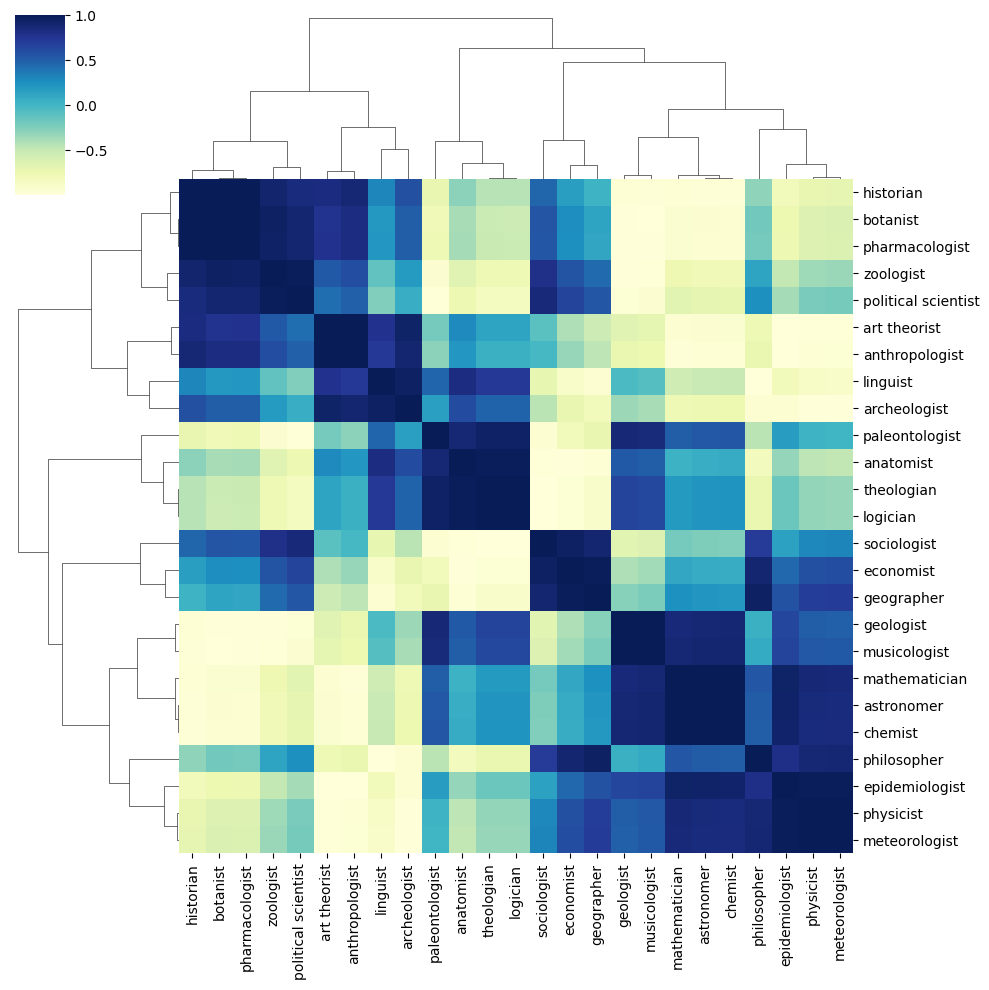

In [43]:
best_index = int(df_mean['Dataset 2'].iloc[0])
best_df = list_df[best_index]
df_net = pl.from_pandas(best_df)
df_edge, df_nodes = get_edge_node_table(df_net)
df_edge.to_csv(f"../networks/matrix/weighted_optimized_before_1700.csv")

df_edge_filter = df_edge[df_edge["weight"] >= dict_op.min_count_link]
df_edge_filter = df_edge_filter[
    df_edge_filter["source"] != df_edge_filter["target"]
]

df_edge_filter = df_edge_filter[
    df_edge_filter["rank_count"] <= 3
]

df_edge_filter = df_edge_filter[['source', 'target', 'weight']].copy()


df_partition, g = sygma_graph_leiden(
    df_edge_filter,
    df_nodes,
    edge_bins=10,
    node_bins=10,
    filepath='../graph/best_jaccard.html',
)
df_partition = df_partition.sort_values("community")
df_partition


import pickle
# Save the 'g' object as a pickle file
with open("../networks/g_objects/g_best_jaccard_weighted.pkl", "wb") as f:
    pickle.dump(g, f)


import pickle
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

network_name = 'g_best_jaccard_weighted'
#network_name = 'g_global_weighted'

# Read the 'g' object from the pickle file
with open(f'../networks/g_objects/{network_name}.pkl', 'rb') as f:
    g = pickle.load(f)

# Use a layout to position nodes (e.g., spring layout)
pos = nx.spring_layout(g)

occupations = list(g.nodes())

# Function to calculate cosine similarity between position vectors
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    return dot_product / (norm1 * norm2)

# Calculate cosine similarity matrix between position vectors
similarity_matrix = np.zeros((len(occupations), len(occupations)))

for i, occupation_i in enumerate(occupations):
    for j, occupation_j in enumerate(occupations):
        pos_i = pos[occupation_i]
        pos_j = pos[occupation_j]
        similarity_matrix[i][j] = cosine_similarity(pos_i, pos_j)

# Create a DataFrame from the similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=occupations, columns=occupations)

# Create a clustermap
sns.clustermap(similarity_df, cmap="YlGnBu", figsize=(10, 10))
plt.show()


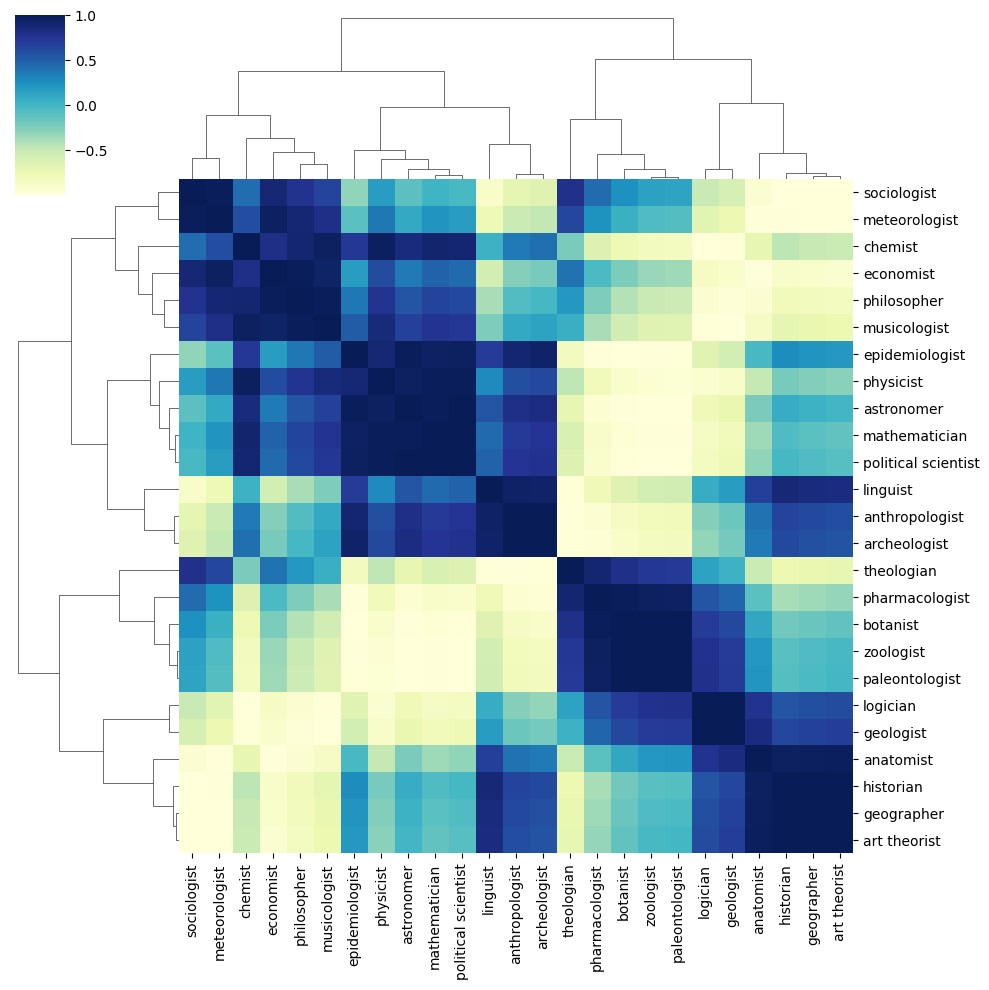

In [27]:
best_index = int(df_mean['Dataset 2'].iloc[1])

best_df = list_df[best_index]
df_net = pl.from_pandas(best_df)
df_edge, df_nodes = get_edge_node_table(df_net)
df_edge.to_csv(f"../networks/matrix/weighted_optimized_before_1700.csv")

df_edge_filter = df_edge[df_edge["weight"] >= dict_op.min_count_link]
df_edge_filter = df_edge_filter[
    df_edge_filter["source"] != df_edge_filter["target"]
]

df_edge_filter = df_edge_filter[
    df_edge_filter["rank_count"] <= 3
]

df_edge_filter = df_edge_filter[['source', 'target', 'weight']].copy()


df_partition, g = sygma_graph_leiden(
    df_edge_filter,
    df_nodes,
    edge_bins=10,
    node_bins=10,
    filepath='../graph/best_jaccard.html',
)
df_partition = df_partition.sort_values("community")
df_partition


import pickle
# Save the 'g' object as a pickle file
with open("../networks/g_objects/g_best_jaccard_weighted.pkl", "wb") as f:
    pickle.dump(g, f)


import pickle
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

network_name = 'g_best_jaccard_weighted'
#network_name = 'g_global_weighted'

# Read the 'g' object from the pickle file
with open(f'../networks/g_objects/{network_name}.pkl', 'rb') as f:
    g = pickle.load(f)

# Use a layout to position nodes (e.g., spring layout)
pos = nx.spring_layout(g)

occupations = list(g.nodes())

# Function to calculate cosine similarity between position vectors
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    return dot_product / (norm1 * norm2)

# Calculate cosine similarity matrix between position vectors
similarity_matrix = np.zeros((len(occupations), len(occupations)))

for i, occupation_i in enumerate(occupations):
    for j, occupation_j in enumerate(occupations):
        pos_i = pos[occupation_i]
        pos_j = pos[occupation_j]
        similarity_matrix[i][j] = cosine_similarity(pos_i, pos_j)

# Create a DataFrame from the similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=occupations, columns=occupations)

# Create a clustermap
sns.clustermap(similarity_df, cmap="YlGnBu", figsize=(10, 10))
plt.show()


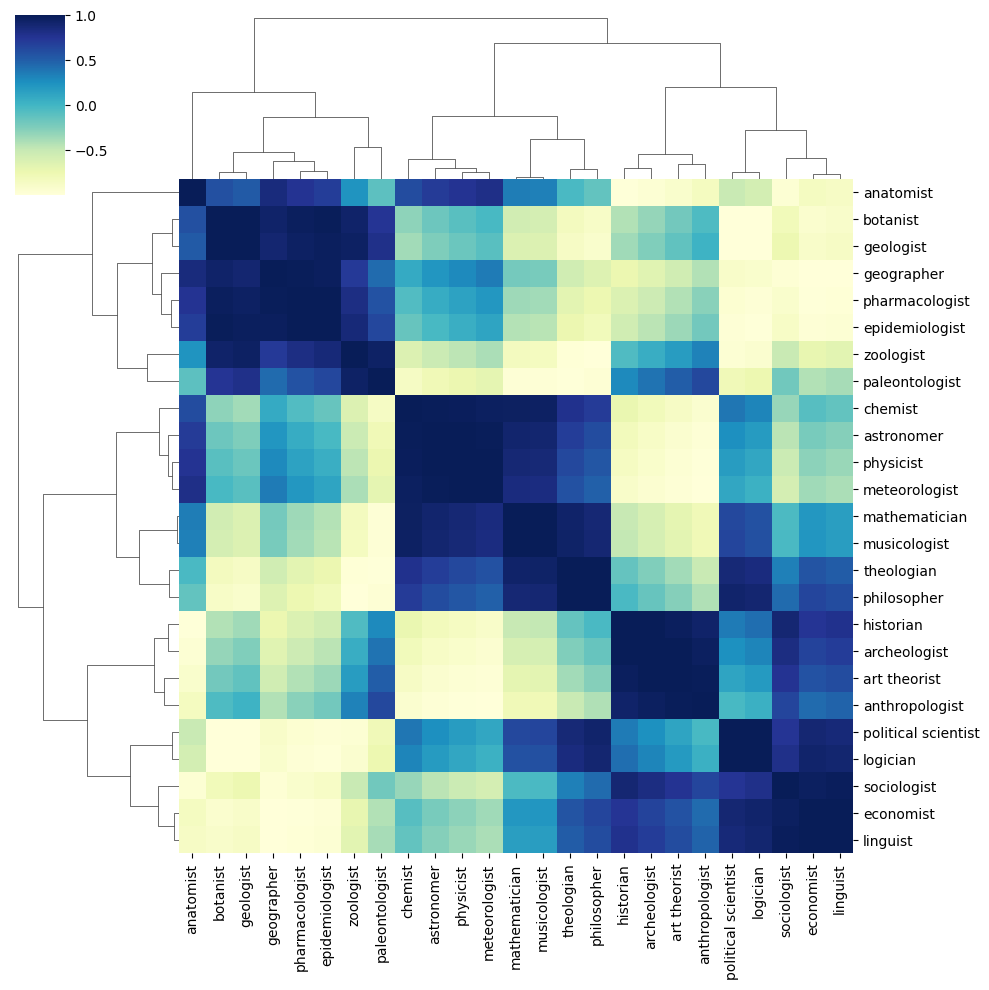

In [29]:
best_index = int(df_mean['Dataset 2'].iloc[2])

best_df = list_df[best_index]
df_net = pl.from_pandas(best_df)
df_edge, df_nodes = get_edge_node_table(df_net)
df_edge.to_csv(f"../networks/matrix/weighted_optimized_before_1700.csv")

df_edge_filter = df_edge[df_edge["weight"] >= dict_op.min_count_link]
df_edge_filter = df_edge_filter[
    df_edge_filter["source"] != df_edge_filter["target"]
]

df_edge_filter = df_edge_filter[
    df_edge_filter["rank_count"] <= 3
]

df_edge_filter = df_edge_filter[['source', 'target', 'weight']].copy()


df_partition, g = sygma_graph_leiden(
    df_edge_filter,
    df_nodes,
    edge_bins=10,
    node_bins=10,
    filepath='../graph/best_jaccard.html',
)
df_partition = df_partition.sort_values("community")
df_partition


import pickle
# Save the 'g' object as a pickle file
with open("../networks/g_objects/g_best_jaccard_weighted.pkl", "wb") as f:
    pickle.dump(g, f)


import pickle
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

network_name = 'g_best_jaccard_weighted'
#network_name = 'g_global_weighted'

# Read the 'g' object from the pickle file
with open(f'../networks/g_objects/{network_name}.pkl', 'rb') as f:
    g = pickle.load(f)

# Use a layout to position nodes (e.g., spring layout)
pos = nx.spring_layout(g)

occupations = list(g.nodes())

# Function to calculate cosine similarity between position vectors
def cosine_similarity(vector1, vector2):
    dot_product = np.dot(vector1, vector2)
    norm1 = np.linalg.norm(vector1)
    norm2 = np.linalg.norm(vector2)
    return dot_product / (norm1 * norm2)

# Calculate cosine similarity matrix between position vectors
similarity_matrix = np.zeros((len(occupations), len(occupations)))

for i, occupation_i in enumerate(occupations):
    for j, occupation_j in enumerate(occupations):
        pos_i = pos[occupation_i]
        pos_j = pos[occupation_j]
        similarity_matrix[i][j] = cosine_similarity(pos_i, pos_j)

# Create a DataFrame from the similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=occupations, columns=occupations)

# Create a clustermap
sns.clustermap(similarity_df, cmap="YlGnBu", figsize=(10, 10))
plt.show()
